In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

sns.set(style="ticks", color_codes=True)

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.python.client import device_lib

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13737174736571909946
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9181283073850899621
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5442514464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16579228538172761278
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4467821554938053060
physical_device_desc: "device: XLA_GPU devic

In [3]:
data,info = tfds.load('caltech_birds2011',split=['train[:90%]','train[90%:]','test'],with_info=True,shuffle_files=True)

In [4]:
train_data = data[0]
valid_data = data[1]
test_data = data[2]

In [5]:
info

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=11788,
    splits={
        'test': 5794,
        'train': 5994,
    },
    supervised_keys=('im

In [6]:
def show_image(train_data,predict=False,predict_features=None):
    data_item = 0
    for item in train_data:
        box = item['bbox']
        image = item['image']
        label = item['label_name'].numpy().decode('UTF-8')        
        width = item['image'].shape[0]
        height = item['image'].shape[1]
        plt.imshow(item['image'].numpy())
        point0 = box[0]*width,box[1]*height
        point1 = box[2]*width,box[1]*height
        point2 = box[2]*width,box[3]*height
        point3 = box[0]*width,box[3]*height
        x_values = [point0[0],point1[0],point2[0],point3[0],point0[0]]
        y_values = [point0[1],point1[1],point2[1],point3[1],point0[1]]
        plt.plot(y_values,x_values,'r--',markersize=60,linestyle='solid')
        plt.text(point0[1],point0[0],s="True",fontsize='xx-large',clip_on=False,color='r')
        if(predict):
            box = predict_features[1][data_item]
            point0 = box[0]*width,box[1]*height
            point1 = box[2]*width,box[1]*height
            point2 = box[2]*width,box[3]*height
            point3 = box[0]*width,box[3]*height
            x_values = [point0[0],point1[0],point2[0],point3[0],point0[0]]
            y_values = [point0[1],point1[1],point2[1],point3[1],point0[1]]
            plt.plot(y_values,x_values,'k--',markersize=60,linestyle='solid')
            plt.text(point0[1],point0[0],s="Predicted",fontsize='xx-large',clip_on=False,color='k')
            data_item += 1
     
        plt.grid(False)
        plt.show()

In [7]:
pretrained_model = True

def preprocessing(item):
    X = tf.cast(item['image'],dtype=tf.float32)
    label = tf.cast(item['label'],dtype=tf.float32)
    box = tf.cast(item['bbox'],dtype=tf.float32)
    X = tf.image.resize_with_pad(X,224,224)
    if pretrained_model:
        X = tf.keras.applications.xception.preprocess_input(X)
    else:
        X = X/255.0
        
    return X,(label,box)

In [8]:
def configure_data(data):
    data = data.map(preprocessing)
    data = data.shuffle(buffer_size = 100)
    data = data.batch(16)
    data = data.prefetch(1)
    return data

In [9]:
train_data = configure_data(train_data)
valid_data = configure_data(valid_data)
test_data  = configure_data(test_data)

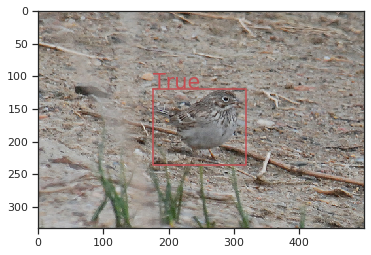

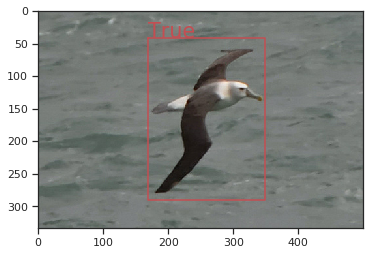

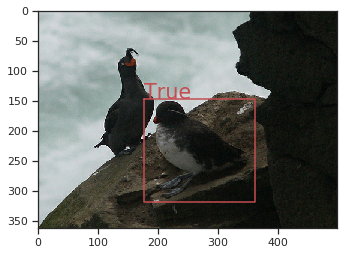

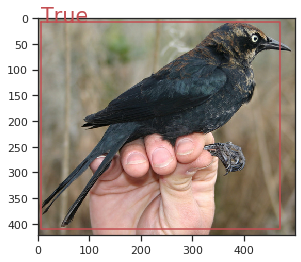

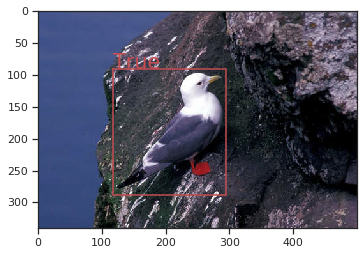

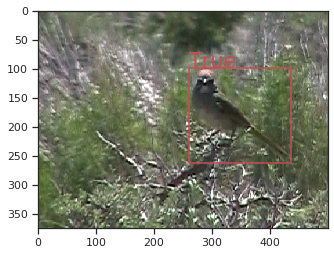

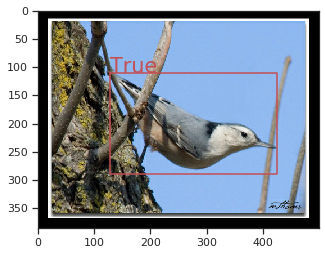

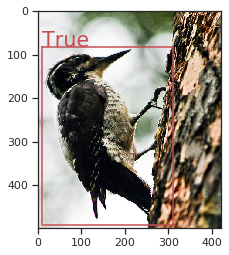

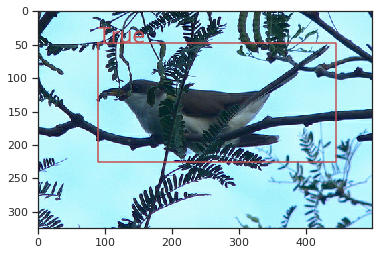

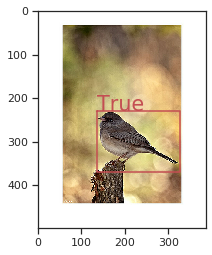

In [10]:
item_temp = [item for item in data[0].take(10)]
show_image(item_temp)

## CNN ResNet Model

In [11]:
class ResUnit(keras.layers.Layer):
    def __init__(self,name,filters=64,strides=1, **kwargs):
        super().__init__(**kwargs)
        self.layer_name=name
        self.strides =strides
        self.filters = filters
        self.activation1 = keras.layers.Activation('relu',name=str(self.layer_name[0])+'_relu')
        self.conv1 = keras.layers.Conv2D(filters=self.filters,kernel_size=(3,3),strides=self.strides,padding="SAME",name=str(self.layer_name[0])+"_main_"+self.layer_name[1])
        self.bn1 = keras.layers.BatchNormalization(name=str(self.layer_name[0])+'_batch_norm')
        
        self.activation2 = keras.layers.Activation('relu',name=str(self.layer_name[0]+1)+'_relu')
        self.conv2 = keras.layers.Conv2D(filters=self.filters,kernel_size=(3,3),strides=(1,1),padding="SAME",name=str(self.layer_name[0]+1)+"_main_"+self.layer_name[1])
        self.bn2 = keras.layers.BatchNormalization(name=str(self.layer_name[0]+1)+'_batch_norm')
        
        
        
    def __call__(self,inputs):
        if(self.strides > 1):
            skip_path = keras.layers.Conv2D(filters=self.filters,kernel_size=(1,1),strides=self.strides,padding="SAME",name=str(self.layer_name[0]+1)+'_skip_conv_1x1')(inputs)
            skip_path = keras.layers.BatchNormalization(name=str(self.layer_name[0]+1)+'_skip_batch_norm')(skip_path)
        else:
            skip_path = inputs
            
        main_path = self.conv1(inputs)
        main_path = self.bn1(main_path)
        main_path = self.activation1(main_path)
        main_path = self.conv2(main_path)
        main_path = self.bn2(main_path)
        
        model = keras.layers.Add(name=str(self.layer_name[0]+1)+'_add')([skip_path,main_path])
        return self.activation2(model)

In [12]:
def ResNet34(in_shape = [224,224,3],n_classes=1000,opt='sgd'):
    in_layer = keras.layers.Input(shape=in_shape,name='input')
    model = keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding="SAME",name='1_7x7_conv_64_2')(in_layer)
    model = keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding="SAME",name='1_pool/2')(model)
    
    prev_filter = 64
    idx_layer = 2
    for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
        strides = 1 if prev_filter == filters else 2
        name = "3x3_conv_" + str(filters) + "_"+ str(strides) 
        model = ResUnit(name=[idx_layer,name],filters=filters,strides=strides)(model)
        idx_layer += 2
        prev_filter = filters
    
    model = keras.layers.GlobalAveragePooling2D(name='34_global_avg_pool_')(model) ##Same For Flatten()
    
    out_layer_class = keras.layers.Dense(units=n_classes,activation='softmax',name='softmax_output')(model)
    out_layer_box= keras.layers.Dense(units=4,name='box')(model)
    
    model = keras.Model(inputs=in_layer, outputs=[out_layer_class,out_layer_box])
    
    model.compile(loss=["sparse_categorical_crossentropy","mse"],loss_weights=[0.8, 0.2],optimizer=opt, metrics=["accuracy"])
    return model

In [13]:
# optimizer = keras.optimizers.SGD(lr=0.002, momentum=0.9, decay=0.01)
# model_resnet34 = ResNet34(in_shape=[224,224,3], n_classes=200, opt=optimizer)
# model_resnet34.summary()

In [14]:
# history_resnet34 = model_resnet34.fit(train_data, epochs=30, validation_data=valid_data)

In [15]:
# history_resnet34 = model_resnet34.fit(train_data, epochs=150, validation_data=valid_data)

In [16]:
# keras.models.save_model(model_resnet34,"caltech_birds2011.h5")

## Transfer learning using Xception

In [17]:
base_model = tf.keras.applications.Xception(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

out_layer_class = keras.layers.Dense(units=200,activation='softmax',name='softmax_output')(avg)
out_layer_box= keras.layers.Dense(units=4,name='box')(avg)
    
model = keras.Model(inputs=base_model.input, outputs=[out_layer_class,out_layer_box])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [18]:
#Must train BN layer ,if not then accuracy will be <10% always
for layer in base_model.layers: # or model.layers[:-1]: 
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy","mse"],loss_weights=[0.8, 0.2],optimizer=optimizer, metrics=["accuracy"])

history_pretrained_xception = model.fit(train_data, epochs=10)#, validation_data=valid_data

Epoch 1/10
169/169 [==============================] - 48s 281ms/step - loss: 3.2436 - softmax_output_loss: 4.0398 - box_loss: 0.0586 - softmax_output_accuracy: 0.1683 - box_accuracy: 0.5472
Epoch 2/10
169/169 [==============================] - 47s 277ms/step - loss: 1.3023 - softmax_output_loss: 1.6206 - box_loss: 0.0289 - softmax_output_accuracy: 0.5778 - box_accuracy: 0.5831
Epoch 3/10
169/169 [==============================] - 47s 278ms/step - loss: 0.7537 - softmax_output_loss: 0.9362 - box_loss: 0.0239 - softmax_output_accuracy: 0.7629 - box_accuracy: 0.5968
Epoch 4/10
169/169 [==============================] - 47s 276ms/step - loss: 0.5317 - softmax_output_loss: 0.6593 - box_loss: 0.0212 - softmax_output_accuracy: 0.8538 - box_accuracy: 0.6059
Epoch 5/10
169/169 [==============================] - 48s 286ms/step - loss: 0.3988 - softmax_output_loss: 0.4936 - box_loss: 0.0195 - softmax_output_accuracy: 0.9003 - box_accuracy: 0.6165
Epoch 6/10
169/169 [==============================

In [20]:
keras.models.save_model(model,"caltech_birds2011_xception_20_epochs.h5")

In [11]:
model = keras.models.load_model("caltech_birds2011_xception_20_epochs.h5")

In [12]:
#Must train BN layer ,if not then accuracy will be <10% always
for layer in model.layers: # or model.layers[:-1]: 
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy","mse"],loss_weights=[0.8, 0.2],optimizer=optimizer, metrics=["accuracy"])

history_pretrained_xception = model.fit(train_data, epochs=10, validation_data=valid_data)#, validation_data=valid_data

Epoch 1/10
338/338 [==============================] - 95s 281ms/step - loss: 0.9519 - softmax_output_loss: 1.1849 - box_loss: 0.0195 - softmax_output_accuracy: 0.6602 - box_accuracy: 0.6056 - val_loss: 1.1382 - val_softmax_output_loss: 1.4172 - val_box_loss: 0.0218 - val_softmax_output_accuracy: 0.6361 - val_box_accuracy: 0.6027
Epoch 2/10
338/338 [==============================] - 93s 276ms/step - loss: 0.1756 - softmax_output_loss: 0.2152 - box_loss: 0.0174 - softmax_output_accuracy: 0.9537 - box_accuracy: 0.6222 - val_loss: 0.9947 - val_softmax_output_loss: 1.2388 - val_box_loss: 0.0186 - val_softmax_output_accuracy: 0.6761 - val_box_accuracy: 0.6093
Epoch 3/10
338/338 [==============================] - 93s 275ms/step - loss: 0.0683 - softmax_output_loss: 0.0814 - box_loss: 0.0163 - softmax_output_accuracy: 0.9946 - box_accuracy: 0.6306 - val_loss: 0.9614 - val_softmax_output_loss: 1.1972 - val_box_loss: 0.0184 - val_softmax_output_accuracy: 0.6878 - val_box_accuracy: 0.6144
Epoch 4

In [12]:
model.evaluate(test_data)

363/363 [==============================] - 24s 67ms/step - loss: 1.0102 - softmax_output_loss: 1.2583 - box_loss: 0.0179 - softmax_output_accuracy: 0.6735 - box_accuracy: 0.6248


[1.010204553604126,
 1.2582870721817017,
 0.01787598431110382,
 0.6734552979469299,
 0.6247842311859131]

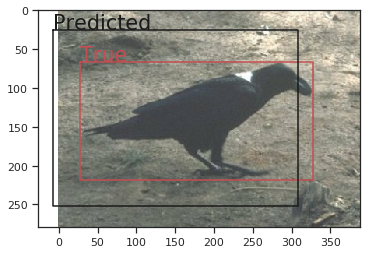

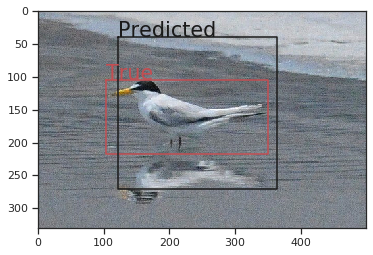

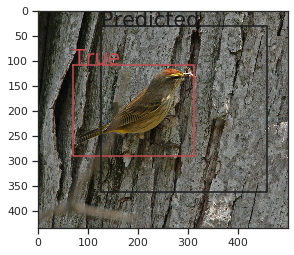

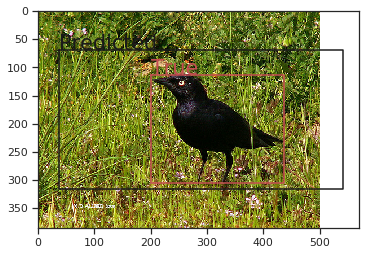

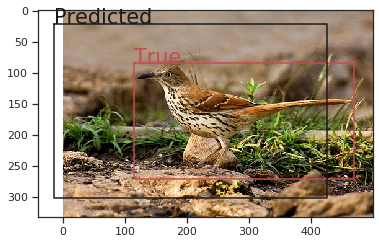

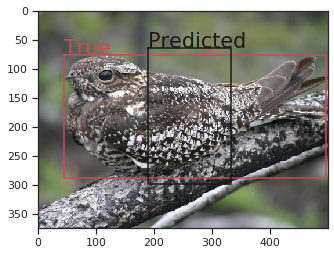

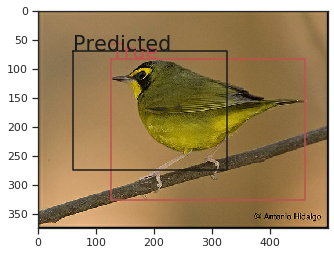

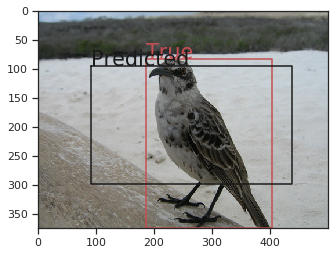

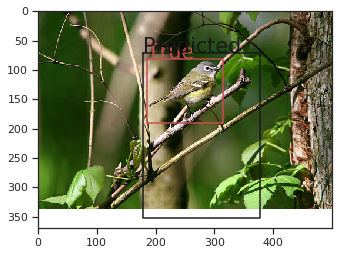

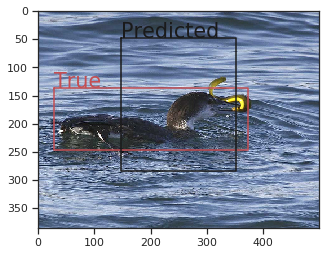

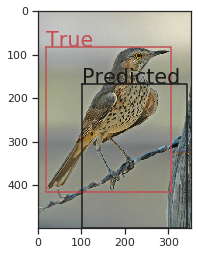

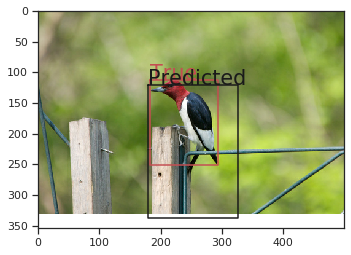

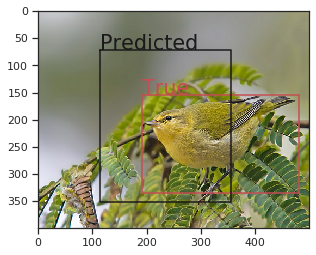

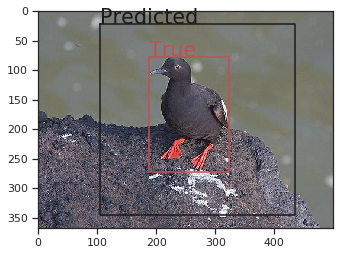

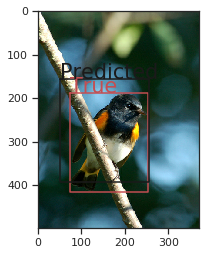

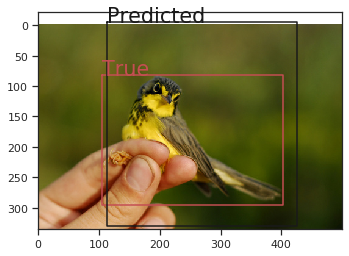

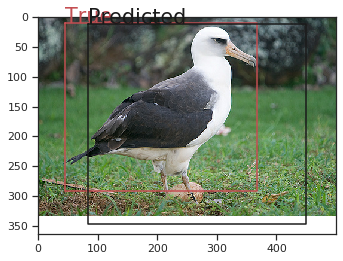

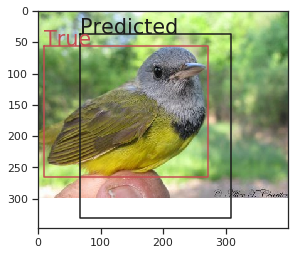

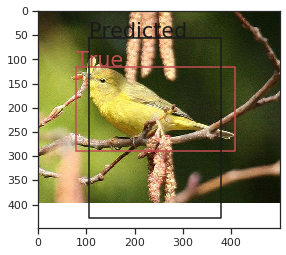

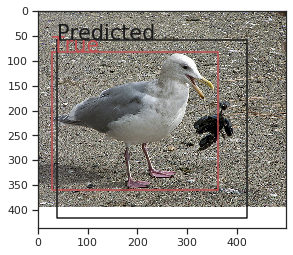

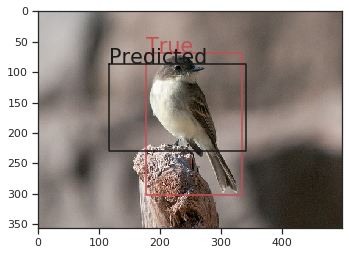

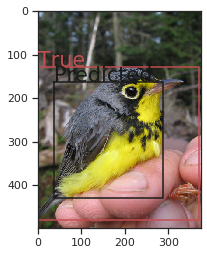

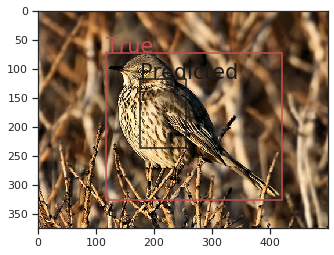

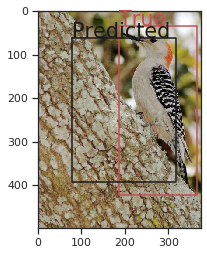

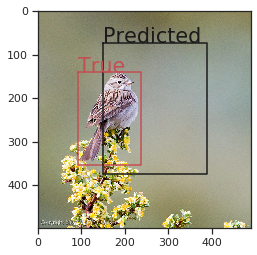

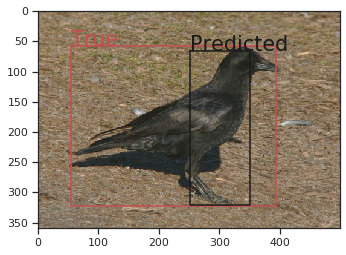

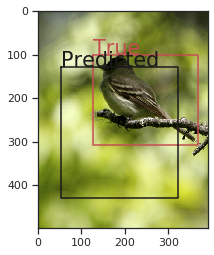

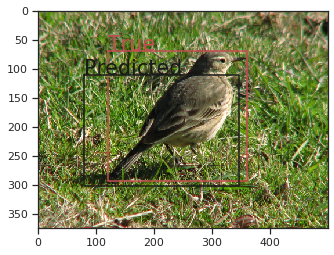

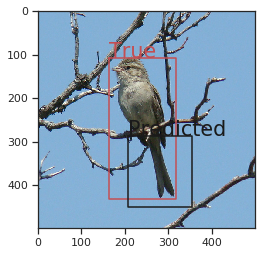

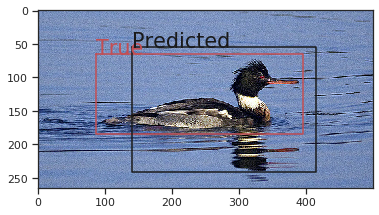

In [13]:
items = data[2].take(30)
item_temp = configure_data(items)
new_set = item_temp.map(lambda X, y: X)
predicted = model.predict(new_set)
show_image(items,predict=True,predict_features=predicted)